# Introduction
## The ESCAPE Virtual Research Environment
The European Science Cluster of Astronomy & Particle physics ESFRI research infrastructures - Virtual Research Environment (https://vre-hub.github.io/), 
is an initiative aimed at fostering collaboration and innovation within the scientific community. 
It seeks to create an open virtual research environment where researchers from diverse fields, including astronomy and particle physics, can collaborate seamlessly, 
share resources, and access advanced computing tools and data analysis techniques. 
### Initial steps
* Follow the  link here https://jhub-vre.cern.ch/
* Use your ESCAPE AAI to connect
* Load the WDF-Virgo environment


## <font color='blue'> How to access, read and plot ET MDC1 data </font>

The Einstein Telescope Data Mock Data Challenge is a collaborative effort within the scientific community to generate and analyze simulated gravitational wave signals that mimic those expected to be detected by the ET. These mock data challenges provide an invaluable opportunity for researchers to evaluate their methods for detecting and characterizing gravitational wave signals under realistic conditions.
The challenge then involves developing and applying data analysis algorithms to identify and extract these signals from the noise, as well as to infer properties of the astrophysical sources that produced them.


## Operative Instructions

This is the first ET-CE MDC. Here are the where, what, how, etc. of the MDSC.

**Where is the data available?**
- Data is available at: `/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1`
- Instructions: [ET-GW Wiki](https://wiki.et-gw.eu/EIB/SoftwareFrameworks/WebHome?validation_key=e2698d03b6eff5856cfab4654d3fbfe5)

**How long is the data set?**
- The data is about one-month long split into 1300 segments of 2048 s, sampled at 8192 Hz. 
- The GW signal and noise are continuous from one segment to the other as well as the waveforms.

**What format is the data in?**
- In Frames for ET V-shaped detectors E1, E2, E3 and the null stream E0, and for Cosmic Explorer L-shaped detectors C1 (Pacific, 40 km) and C2 (Gulf of Mexico, 20 km). 
- Future releases will have hdf5 format. 
- Represents 1.3 TB in total for ET alone.

**What does the data contain?**
- Two sets of data:
  1. GW signal+noise in `MDC1/data/E0,E1,E2,E3,C1,C2`
  2. Noise only in `MDC1/noise/E0,E1,E2,E3,C1,C2`
- GW signal from BNS (59540), BBH (6578), and BHNS (1977) populations
- Colored Gaussian noise with no noise artifacts at the moment. 
- Noise PSD mimicking the expected PSDs of ET 10 km, and of CE 40 km & 20 km [ET PSD](https://wiki.et-gw.eu/OSB/CoBA?validation_key=57de62e375f00b98500a2368e16785d8) and [CE PSD](https://cosmicexplorer.org/sensitivity.html)

**Which Waveforms were used?**
- For BNS: IMRPhenomPNRv2 (NRTidalv2_V) with no spins.
- For BBH: IMRPhenomXPHM.
- For NSBH: IMRPhenomXPHM.

**Are the source parameters available?**
- Lists of sources available in the folders `params/paramsET` and `params/paramsCE` for each segment (`params_$segment.dat`) with the optimal expected SNR for ET and CE. 
- Full list for the complete dataset available in the folder `lists` (`list_mdc1.txt`).

**Parameter Columns:**
- `params_$segment.dat`: 
  - `#, starting_time, final_time, time@Maximum, ... snr_optimal, type (BNS=1, BHNS=2, BBH=3)`
- `list_mdc1.txt`:
  - `#, starting_time, final_time, time@Maximum, ... snrET_optimal, snrCE_optimal, type (BNS=1, BHNS=2, BBH=3)`

Note: Starting and final times are given for the center of the Earth. Exact times at the detectors have a delay (a few or a few tens of milliseconds) depending on the position of the source and the location of the detectors.


## List of injected signals

**Modified from https://gitlab.et-gw.eu/osb/div10/mdc-tutorial**

In [1]:
# added by LIA to suppress warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
from lal import LIGOTimeGPS

In [2]:
# Importing the sys module to manipulate the Python runtime environment
import sys

# Adding a specific path to the beginning of the sys.path list
# This path points to a directory containing Python packages
# This is typically done to ensure that the desired version of a package is used
# In this case, the path points to the site-packages directory of the igwn-py39 environment
#sys.path = ['/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages'] + sys.path    ## removed by LIA as we are not using cvmfs

In [3]:
# Importing the pyplot module from the matplotlib library and aliasing it as plt
from matplotlib import pyplot as plt

# Importing the gwpy library, which provides tools for gravitational wave data analysis
import gwpy

# Importing the TimeSeries class from the gwpy.timeseries module
from gwpy.timeseries import TimeSeries

# Importing the NumPy library and aliasing it as np
import numpy as np

# Importing the Pandas library and aliasing it as pd
import pandas as pd

# Importing the seaborn library for statistical data visualization
import seaborn as sns
 


### if needed, prepare the ffl files

In [4]:
# Import necessary modules
from glob import glob
import os
import logging
import coloredlogs

# Install coloredlogs for improved logging output
coloredlogs.install(isatty=True)

# Define the path to the injection data
inj_data_path = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data/C2"

# Log information about reading paths to GWFs with injections
logging.info("Reading paths to GWFs with injections.")

# Define the path to store temporary FFL file
tmpffl = '../caches/C2.ffl'

# Open the temporary FFL file for writing
with open(tmpffl, 'w') as f:
    # Write lines to the FFL file, containing information about each GWF file
    # Information includes the filename, the second-to-last part of the filename (presumably some identifier), and the file extension (excluding '.')
    f.writelines(f"{gwf} {int(gwf.split('-')[-2])} {int(os.path.splitext(gwf.split('-')[-1])[0])} 0 0\n" for gwf in sorted(glob(os.path.join(inj_data_path, "*.gwf"))))
    # Close the file explicitly (though it's unnecessary due to the use of `with` statement)

# Log information about the completion of FFL creation
logging.info("FFL created.")

 

2025-02-13 15:02:33 jupyter-lialavezzi root[365] INFO Reading paths to GWFs with injections.
2025-02-13 15:02:33 jupyter-lialavezzi root[365] INFO FFL created.


In [5]:
# Setting the path to the directory containing the Einstein Telescope Mock Data Challenge 1 (MDC1) data
MDC_PATH = "/cvmfs/et-gw.osgstorage.org/et-gw/PUBLIC/MDC1/data"

# Defining a list of datasets, each identified by a string (E0, E1, ..., C2)
DATASETS = ['E0','E1','E2','E3','C1','C2']

# Creating a dictionary to map each dataset to its corresponding channel
# Each channel is specified as a string with the dataset name followed by ":STRAIN"
CHANNELS = {n : f'{n}:STRAIN' for n in DATASETS}

In [6]:
# Reading a gravitational wave strain time series from a GWF file using the gwpy library
# The file path is constructed based on the MDC_PATH and dataset ('E1') information
e0 = TimeSeries.read(MDC_PATH+'/E1/E-E1_STRAIN_DATA-1000000000-2048.gwf', 'E1:STRAIN')

# Printing the first 10 elements of the TimeSeries object (time series data)
# The TimeSeries object contains various metadata and information about the strain data
print(e0[1:10])


TimeSeries([-5.54284896e-23,  8.72894580e-23, -1.52215950e-22,
             1.93370972e-22, -1.56591158e-22,  2.12791581e-22,
            -7.75441870e-23, -5.23293157e-23, -7.15922186e-23]
           unit: strain,
           t0: 1000000000.0001221 s,
           dt: 0.0001220703125 s,
           name: E1:STRAIN,
           channel: None)


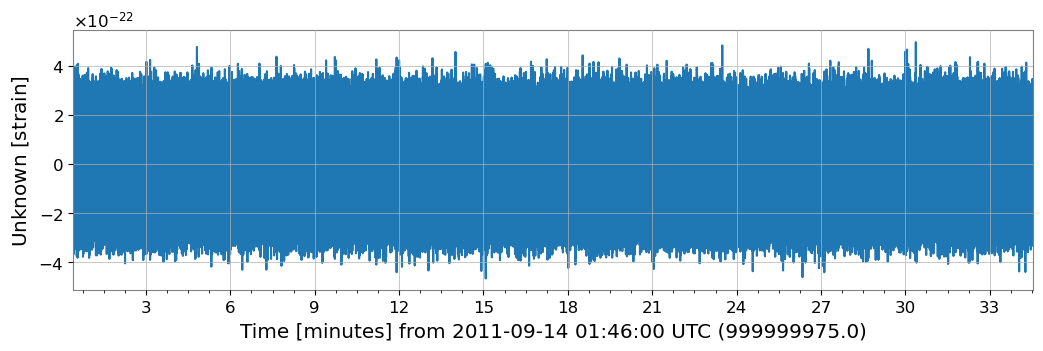

In [7]:
# Enabling inline plotting in Jupyter notebooks or IPython environments
#%matplotlib inline   # removed by LIA (it does not work with inline)

# Creating a plot of the gravitational wave strain data using the plot() method of the TimeSeries object
plot = e0.plot()


### How to plot only the signal on a given time window

In [8]:
# Importing the lal module, which is part of the LIGO Scientific Collaboration (LSC) software stack
import lal

def read_without_warnings(cachefile, channel, **kwargs):
    """
    Reads cache file while suppressing spurious LAL warnings.
    Wraps gwpy.timeseries.TimeSeries.read

    Args:
        cachefile (str): path to cache file
        channel (str): Channel name
        **kwargs: additional arguments passed to TimeSeries.read
    """
    # Storing the previous debug level to later restore it
    prev_level = lal.GetDebugLevel()

    # Temporarily setting the LAL debug level to 0 (suppressing warnings)
    lal.ClobberDebugLevel(0)

    # Reading the cache file using gwpy.timeseries.TimeSeries.read
    result = TimeSeries.read(cachefile, channel, **kwargs)

    # Restoring the original LAL debug level
    lal.ClobberDebugLevel(prev_level)

    # Returning the result (TimeSeries object)
    return result

def get_strain(file, channel, tc, t_before=4, t_after=1):
    """
    Reads a portion of strain data from a cache file centered around a specified time.
    
    Args:
        file (str): Path to the cache file
        channel (str): Channel name
        tc (float): Time center around which to read strain data
        t_before (float): Time before the center time to include in the data
        t_after (float): Time after the center time to include in the data

    Returns:
        TimeSeries: Portion of the strain data centered around the specified time
    """
    # Calculating the start and end times based on the specified time center and time intervals
    start_time = tc - t_before
    end_time = tc + t_after

    # Reading the strain data from the cache file without generating LAL warnings
    h = read_without_warnings(file, channel, start=start_time, end=end_time)

    # Returning the TimeSeries object containing the strain data
    return h


In [9]:
# Importing the Pandas library and aliasing it as pd
import pandas as pd

# Reading a CSV file containing metadata about signals
# The file is assumed to be located one level up in the directory structure
df = pd.read_csv('../metadata/list_mdc1.txt', sep=' ')
signals=df.sort_values(by=['snrET_Opt'],ascending=False)
# Choosing the top few signals (Nsig = 4)
Nsig = 4
top_sigs = signals.iloc[:Nsig]

# Iterating over the top signals and printing relevant information
for idx, pars in top_sigs.iterrows():
    # Printing information about each signal
    print(f'Inj {int(pars["#"])}, tc {pars["tc"]}, SNR {pars["snrET_Opt"]}')


Inj 42581, tc 1001620463.11925, SNR 587.553918
Inj 42634, tc 1001622678.23317, SNR 386.213044
Inj 35118, tc 1001338345.05655, SNR 383.954083
Inj 41037, tc 1001560353.66079, SNR 374.579215


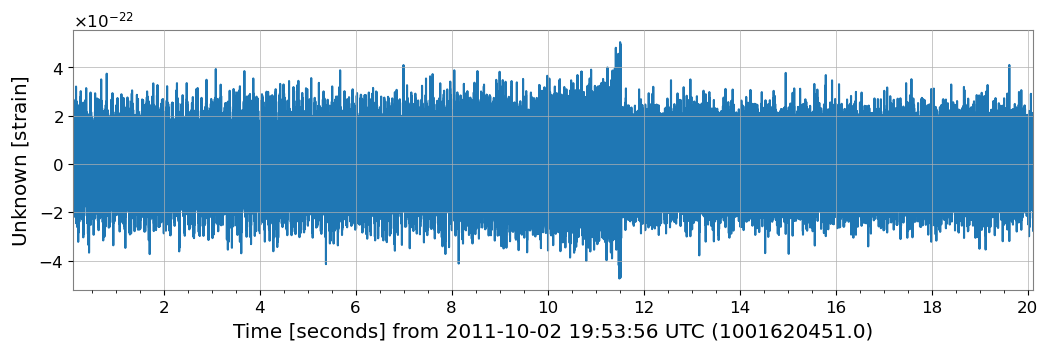

In [10]:
# Specifying the path to the cache file
file = '../caches/E1.lcf'

# Specifying the channel name
channel = 'E1:STRAIN'

# Specifying the time center for reading strain data
tc = 1001620463.11925

# Reading a portion of strain data from the cache file centered around the specified time
# The data includes a time window of 12 seconds before and 8 seconds after the center time
h = get_strain(file, channel, tc, t_before=12, t_after=8)

# Plotting the strain data
h.plot()

# Displaying the plot
plt.show()


## Signal distribution

There are 6767 signals with SNR>15.


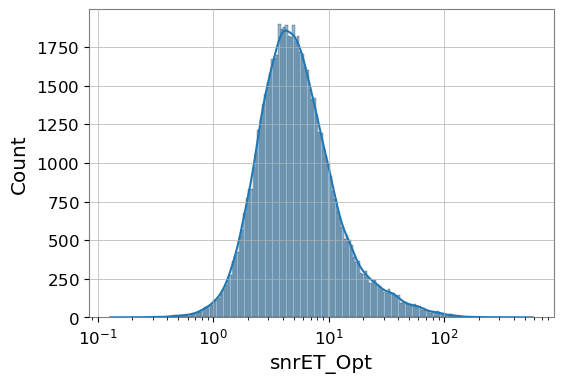

In [11]:
# Plot distribution of SNRs
print(f'There are {sum(signals["snrET_Opt"]>15)} signals with SNR>15.')
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.histplot(signals['snrET_Opt'], log_scale=(True,False), kde=True, ax=ax)
plt.show()


## <font color='purple'> Challenge: Could you plot the time serie for the signal with lowest SNR? </font>